In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from math import dist
import itertools
import glob as glob
import os

In [2]:
### goal: compare change in stability (due to mutation) vs. number of contacts for wt hphob residues


In [2]:
### chdir to where the dms pdbs are 
os.chdir('/Volumes/GoogleDrive-115723536581609915601//My Drive/01_HEEH_design/data/pdbs/rd5_dms_lowest_models')

### get all filenames of dms pdbs by alphafold
#all_dms_pdbs = glob.glob('*pdb')

In [3]:
pwd

'/Volumes/GoogleDrive-115723536581609915601/My Drive/01_HEEH_design/data/pdbs/rd5_dms_lowest_models'

In [4]:
####
wt_files = ['HEEH_TK_rd5_0018.pdb_fasta_unrelaxed_model_1_ptm.pdb',
            'HEEH_TK_rd5_0341.pdb_fasta_unrelaxed_model_1_ptm.pdb',
            'HEEH_TK_rd5_0420.pdb_fasta_unrelaxed_model_1_ptm.pdb',
            'HEEH_TK_rd5_0614.pdb_fasta_unrelaxed_model_1_ptm.pdb',
            'HEEH_TK_rd5_0958.pdb_fasta_unrelaxed_model_1_ptm.pdb',
            'HEEH_TK_rd5_3711.pdb_fasta_unrelaxed_model_1_ptm.pdb']

### prepare pdb filenames

In [5]:
#def subset_pdbs(design):
#    ''' return list of dms pdb filenames by design name 18, 341, 420, 614, 958, or 3711 '''
#    return [pdb for pdb in all_dms_pdbs if design in pdb]

In [6]:
def get_wt_filename(pdbs):
    ''' get wt pdb file '''
    wt = []
    #mutants = []
    for file in pdbs:
        if file.split('_')[4].split('.')[0] == 'fasta': # find wt file
            wt.append(file)
        #else:
    #       mutants.append(file)
    return wt[0]#, mutants

### open file, get atomic coord for b-carbon

In [7]:
def wt_bcarbon(pdb):
    ''' return df with atomic coordinates of b-carbon for wt '''
    with open(pdb, 'r') as file:
        data = file.read().splitlines()
    new_data = []
    for line in data[1:]:
        new_data.append(line.split())
    df = pd.DataFrame(new_data, columns=['atom', 'atom_num', 'atom_type', 'residue', 'chain', 'res_pos', 'x', 'y', 'z', 'occupancy', 'b-factor', 'atom2'])
    df=df.dropna()
    df['atom_num'] = df['atom_num'].astype(int)
    df['res_pos'] = df['res_pos'].astype(int)
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    df['z'] = df['z'].astype(float)
    df.drop(columns=['b-factor', 'atom2', 'occupancy', 'chain'], inplace=True)
    df=df.query('atom_type=="CB"')
    return df

In [8]:
def res_type(df):
    ''' add column with 1-letter residue abbreviation'''
    aa_dict = {'GLY':'G',
               'ALA':'A',
              'VAL':'V',
              'LEU':'L',
              'ILE':'I',
              'PRO':'P',
              'MET':'M',
              'TRP':'W',
              'PHE':'F',
              'GLN':'Q',
              'ASN':'N',
              'TYR':'Y',
              'SER':'S',
              'THR':'T',
              'HIS':'H',
              'ARG':'R',
              'LYS':'K',
              'ASP':'D',
              'GLU':'E',}

    all_abbrev = []
    for res in list(df['residue']):
        abbrev = aa_dict[res]
        all_abbrev.append(abbrev)
    df['res'] = all_abbrev
    
#    res_id = []
#    for res in df['res']:
#        if res in 'AFILMWVY':
#            res_id.append('hphob')
#        elif res in 'QNCYST':
#            res_id.append('polar')
#        elif res in 'HRKDE':
#            res_id.append('charged')
#    df['res_type'] = res_id
    return df

In [9]:
#def res_id_type(df):
    ''' keep b-carbon atomic coord for hphob res'''

    return df #df.query('res == "A" or res=="F" or res=="I" or res=="L" or res=="M" or res=="W" or res=="V" or res=="Y"') 


IndentationError: unexpected indent (3797354859.py, line 2)

### get pairwise distances

In [10]:
def pairwise_dist(df, design):
    ''' returns data on the euclidean distance for all possible beta carbon positions in rosetta model) '''

    pairwise = list(itertools.permutations(df['res_pos'], 2)) # get all pairwise position combinations
    
    pairs = []
    pairwise_dist = []
    res1_type = []
    res2_type = []
    
    for pair in pairwise:
        first_pair = pair[0]
        second_pair = pair[1]
        
        res1 = df.query('res_pos==@first_pair')['res'].tolist()[0]
        res2 = df.query('res_pos==@second_pair')['res'].tolist()[0]
        # get coordinates
        first_x = float(df.query('res_pos==@first_pair')['x'])
        first_y = float(df.query('res_pos==@first_pair')['y'])
        first_z = float(df.query('res_pos==@first_pair')['z'])
        first_coord = np.array((first_x, first_y, first_z), dtype=float)
        second_x = float(df.query('res_pos==@second_pair')['x'])
        second_y = float(df.query('res_pos==@second_pair')['y'])
        second_z = float(df.query('res_pos==@second_pair')['z'])
        second_coord = np.array((second_x, second_y, second_z), dtype=float)
        # calculate distance
        distance = np.linalg.norm(first_coord-second_coord)
        # add results to lists
        pairs.append(pair)
        pairwise_dist.append(distance)
        res1_type.append(res1)
        res2_type.append(res2)
        
    newdf = pd.DataFrame(pairs, columns=['pos1', 'pos2'])
    newdf['pos_pair'] = pairs
    newdf['dist'] = pairwise_dist
    newdf['res1'] = res1_type
    newdf['res2'] = res2_type
    newdf['design'] = 'HEEH_TK_rd5_'+ design
    return newdf


In [11]:
def keep_dist_close_contact(df):
    ''' distance < 7A'''
    return df.query('dist < 8')

In [12]:
def n_contacts(df):
    ''' quantify number of contacts and add it to df '''

    newdf=pd.DataFrame()
    for design in ['HEEH_TK_rd5_0018', 'HEEH_TK_rd5_0341', 'HEEH_TK_rd5_0420', 'HEEH_TK_rd5_0614',
                   'HEEH_TK_rd5_0958', 'HEEH_TK_rd5_3711']: 
        
        subdf=df.query('design==@design')
        contact_counts = subdf['pos1']
        df_contacts = contact_counts.value_counts().rename_axis('pos1').reset_index(name='n_contacts') # turn contacts freq into df
        
        subdf=pd.merge(left=subdf, right=df_contacts, on='pos1', how='inner')
        
        newdf = pd.concat([newdf, subdf])
        
    return newdf 



#def n_contacts(df):
#    ''' adds number of contacts a residue  '''
#    contacts = df.query('dist < 8')['pos1'] # get position whose contacts < 8A
#    newdf = contacts.value_counts().rename_axis('pos').reset_index(name='n_contacts') # turn
#    return newdf

In [13]:
def final(design):
    list_pdb_filenames = subset_pdbs(design)
    wt_file = get_wt_filename(pdbs=list_pdb_filenames)
    bcarbon_coord = wt_bcarbon(pdb=wt_file)
    bcarbon_coord = res_type(df=bcarbon_coord)
    #bcarbon_coord2 = res_id_type(df=bcarbon_coord)
    pairwise = pairwise_dist(df=bcarbon_coord, design=design)
    close_contacts_df = keep_dist_close_contact(df=pairwise)
    n_contacts_df = n_contacts(df=close_contacts_df)
    return n_contacts_df
    #return bcarbon_coord

### get df for all 6 designs with pairwise distances < 8A 


In [14]:
pairwise_df=pd.DataFrame()

for design in ['0018', '0341', '0420', '0614', '0958', '3711']:
    subdf = final(design=design)
    pairwise_df = pd.concat([pairwise_df, subdf])
    

NameError: name 'subset_pdbs' is not defined

### get dms stability score data

In [15]:
os.chdir('/Volumes/GoogleDrive-115723536581609915601/My Drive/01_HEEH_design/2022_HEEH_manuscript/Revised submission PNAS/SI Appendix/data/stability_scores/')



In [16]:
pwd

'/Volumes/GoogleDrive-115723536581609915601/My Drive/01_HEEH_design/2022_HEEH_manuscript/Revised submission PNAS/SI Appendix/data/stability_scores'

In [17]:
def get_dms_stability():
    ''' output dms dataframe for wt and mutants '''
    dms = pd.read_csv('rd5_deep_mutational_scanning_stability_scores.csv')
    # add columns
    dms['design'] = [ name.split('.')[0] for name in dms['name']]
    dms['mutant'] = [ name.split('_')[-1] for name in dms['name']]
    dms['type'] = [ 'wt' if mut[-1]=='b' else 'mut' for mut in dms['mutant']]
    
    wt_df = dms.query('type=="wt"')
    wt_df.rename(columns={'stabilityscore':'wt_stabilityscore'}, inplace=True) # rename column
    mut_df = dms.query('type=="mut"')
    
    mut_df['pos'] = [ int(x[1:3]) if x[2] in '1234567890'  else int(x[1]) for x in mut_df['mutant']]
    mut_df.rename(columns={'stabilityscore':'mut_stabilityscore'}, inplace=True) # rename column
    return wt_df[['design', 'wt_stabilityscore']], mut_df[['design', 'mutant', 'pos', 'mut_stabilityscore']]

In [18]:
#def add_wt_stability(pairwise, wt_df):
#    ''' add wt stability score to pairwise df'''
#    merge = pd.merge(left=pairwise, right=wt_df, on='design', how='inner')
#    return merge

In [19]:
def add_avg_mut_stability(mut_df):
    ''' from dms df, make newdf with pos and average mut stability score at each position '''
    positions = np.unique(mut_df['pos'])
    
    merge_df = pd.DataFrame() # this df will have design, pos, avg_mut_stability
    
    for design in ['HEEH_TK_rd5_0018', 'HEEH_TK_rd5_0341', 'HEEH_TK_rd5_0420', 'HEEH_TK_rd5_0614',
                   'HEEH_TK_rd5_0958', 'HEEH_TK_rd5_3711']:
    
        subset_df = mut_df.query('design==@design')  # subset df by design
        avg_stability_pos = {}
        for position in positions:
            pos_df = subset_df.query('pos==@position') # subset design df by res position
            avg_stability = np.mean(pos_df['mut_stabilityscore']) # average mutant stabilityscore
            avg_stability_pos[position]=avg_stability # add avg mut stabilityscore to dict
        
        dict_df = pd.DataFrame(avg_stability_pos.items(), columns=['pos1', 'avg_mut_stability']) # convert dict to df
        dict_df['design'] = design # add design name as a column
        merge_df=pd.concat([merge_df, dict_df])
    
    return merge_df

In [20]:
####def merge_pairwise_avg_mut(pairwise, avg_mut):
    
newdf=pd.DataFrame()

for design in ['HEEH_TK_rd5_0018', 'HEEH_TK_rd5_0341', 'HEEH_TK_rd5_0420', 'HEEH_TK_rd5_0614',
               'HEEH_TK_rd5_0958', 'HEEH_TK_rd5_3711']: 
    sub_pairwise_df = pairwise.query('design==@design') # subset df by design
    sub_avgmut_df = avg_mut.query('design==@design') # subset avgmut df by design

    merge_subdf = pd.merge(left=sub_pairwise_df, right=sub_avgmut_df[['pos1','avg_mut_stability' ]], 
                     on='pos1', how='inner') # merge

    newdf=pd.concat([newdf, merge_subdf])
newdf['avg_change_mut_stability'] = newdf['avg_mut_stability']-newdf['wt_stabilityscore']
return newdf

NameError: name 'pairwise' is not defined

In [21]:
#####def final():
    wt_df, mut_df = get_dms_stability()
    merge_pairwise_wt_df = add_wt_stability(pairwise=pairwise_df, wt_df=wt_df) # add wt
    
    avg_mut_stability = add_avg_mut_stability(mut_df=mut_df)
    
    merge_pairwise_wt_avgmut_df = merge_pairwise_avg_mut(pairwise=merge_pairwise_wt_df, avg_mut=avg_mut_stability)
    
    
    return merge_pairwise_wt_avgmut_df

IndentationError: unexpected indent (2441790673.py, line 2)

In [22]:
def merge_wt_mut(wt_df, mut_df):
    merge_df = pd.merge(left=wt_df, right=mut_df, on='design', how='outer')
    return merge_df

In [23]:
def change_stability(df):
    df['change_avg_stability'] = df['avg_mut_stability']-df['wt_stabilityscore']
    return df

### get burial data

In [24]:
os.chdir('/Volumes/GoogleDrive-115723536581609915601/My Drive/01_HEEH_design/datasets/')


In [61]:
def get_burial_data():
    all_files = glob.glob('*burial')
    design_names = []
    design_info = []

    for file in all_files:

        name = (str(file).split('.')[0])
        print(name)

        with open (file, 'r') as file:
            pos_res_burial = file.readlines()


            for line in pos_res_burial:

                x = line.split('\t')
                pos = int(x[0])
                res = x[1]
                burial = float(x[2].strip('\n'))


                info = (pos, res, burial)

                design_names.append(name)
                design_info.append(info)

       # print(design_names)
        #print(design_info)

    df = pd.DataFrame(design_info, columns=['pos1', 'residue', 'burial'])
    df['design']=design_names

    return df.sort_values(['design','pos1'], ascending=True)
    #df.to_csv('burials.csv', index=False, header=True)

In [26]:
def merge_burial(burial_df, merge_df):
    df = pd.merge(left = burial_df, right = merge_df, 
                        left_on=['design', 'pos'], 
                        right_on=['design', 'pos1'],
                        how='inner')
    return df             

In [62]:
def final2():
    ''' add burial df '''
    wt_df, mut_df = get_dms_stability()
    avg_mut_df = add_avg_mut_stability(mut_df=mut_df)
    merge = merge_wt_mut(wt_df=wt_df, mut_df=avg_mut_df)
    merge = change_stability(df=merge)
    burial = get_burial_data()
    #merge_b = merge_burial(burial_df=burial, merge_df=merge)
    return merge, burial

In [80]:
b

,pos1,residue,burial,design
215,1,SER,0.166321,HEEH_TK_rd5_0018
216,2,PHE,1.672572,HEEH_TK_rd5_0018
217,3,GLU,0.009306,HEEH_TK_rd5_0018
218,4,GLU,0.248013,HEEH_TK_rd5_0018
219,5,LEU,0.968794,HEEH_TK_rd5_0018
...,...,...,...,...
38,39,ALA,5.030638,HEEH_TK_rd5_3711
39,40,ARG,0.753280,HEEH_TK_rd5_3711
40,41,ARG,0.683381,HEEH_TK_rd5_3711
41,42,TRP,0.710205,HEEH_TK_rd5_3711


In [63]:
a,b=final2()

/Users/tek317/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/var/folders/35/r7mlztxx5bj0x1y0f49pww80cq0ykg/T/ipykernel_10044/948323010.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_df['pos'] = [ int(x[1:3]) if x[2] in '1234567890'  else int(x[1]) for x in mut_df['mutant']]


HEEH_TK_rd5_3711
HEEH_TK_rd5_0958
HEEH_TK_rd5_0614
HEEH_TK_rd5_0420
HEEH_TK_rd5_0341
HEEH_TK_rd5_0018


In [66]:
c=pd.merge(left=a.query('design=="HEEH_TK_rd5_0958"'), right=b.query('design=="HEEH_TK_rd5_0958"'), 
           on='pos1', how='inner')

In [91]:
c=pd.merge(left=a, right=b, 
           on='pos1', how='inner')

In [92]:
def res_type(df):
    ''' add column with 1-letter residue abbreviation'''
    aa_dict = {'GLY':'G',
               'ALA':'A',
              'VAL':'V',
              'LEU':'L',
              'ILE':'I',
              'PRO':'P',
              'MET':'M',
              'TRP':'W',
              'PHE':'F',
              'GLN':'Q',
              'ASN':'N',
              'TYR':'Y',
              'SER':'S',
              'THR':'T',
              'HIS':'H',
              'ARG':'R',
              'LYS':'K',
              'ASP':'D',
              'GLU':'E',}

    all_abbrev = []
    for res in list(df['residue']):
        abbrev = aa_dict[res]
        all_abbrev.append(abbrev)
    df['res'] = all_abbrev
    
#    res_id = []
#    for res in df['res']:
#        if res in 'AFILMWVY':
#            res_id.append('hphob')
#        elif res in 'QNCYST':
#            res_id.append('polar')
#        elif res in 'HRKDE':
#            res_id.append('charged')
#    df['res_type'] = res_id
    return df

In [93]:
c=res_type(df=c)

In [94]:
c

,design_x,wt_stabilityscore,pos1,avg_mut_stability,change_avg_stability,residue,burial,design_y,res
0,HEEH_TK_rd5_0018,2.857318,1,2.669868,-0.187450,SER,0.166321,HEEH_TK_rd5_0018,S
1,HEEH_TK_rd5_0018,2.857318,1,2.669868,-0.187450,ASP,0.304882,HEEH_TK_rd5_0341,D
2,HEEH_TK_rd5_0018,2.857318,1,2.669868,-0.187450,SER,0.164321,HEEH_TK_rd5_0420,S
3,HEEH_TK_rd5_0018,2.857318,1,2.669868,-0.187450,ASP,0.464834,HEEH_TK_rd5_0614,D
4,HEEH_TK_rd5_0018,2.857318,1,2.669868,-0.187450,ASP,0.492239,HEEH_TK_rd5_0958,D
...,...,...,...,...,...,...,...,...,...
1543,HEEH_TK_rd5_3711,2.256550,43,2.001365,-0.255184,ILE,1.746889,HEEH_TK_rd5_0341,I
1544,HEEH_TK_rd5_3711,2.256550,43,2.001365,-0.255184,ILE,2.678907,HEEH_TK_rd5_0420,I
1545,HEEH_TK_rd5_3711,2.256550,43,2.001365,-0.255184,LEU,2.162661,HEEH_TK_rd5_0614,L
1546,HEEH_TK_rd5_3711,2.256550,43,2.001365,-0.255184,GLY,NaN,HEEH_TK_rd5_0958,G


In [95]:
def res_abbrev(df):
    res_id = []

    for res in df['res']:
        if res in 'AFILMWVY':
            res_id.append('hphob')
        elif res in 'QNCST':
            res_id.append('polar')
        elif res in 'HRKDE':
            res_id.append('charged')
        elif res =='P':
            res_id.append('P')
        else:
            res_id.append('G')

    df['res_type'] = res_id
    return df

In [96]:
c=res_abbrev(df=c)

In [97]:
c

,design_x,wt_stabilityscore,pos1,avg_mut_stability,change_avg_stability,residue,burial,design_y,res,res_type
0,HEEH_TK_rd5_0018,2.857318,1,2.669868,-0.187450,SER,0.166321,HEEH_TK_rd5_0018,S,polar
1,HEEH_TK_rd5_0018,2.857318,1,2.669868,-0.187450,ASP,0.304882,HEEH_TK_rd5_0341,D,charged
2,HEEH_TK_rd5_0018,2.857318,1,2.669868,-0.187450,SER,0.164321,HEEH_TK_rd5_0420,S,polar
3,HEEH_TK_rd5_0018,2.857318,1,2.669868,-0.187450,ASP,0.464834,HEEH_TK_rd5_0614,D,charged
4,HEEH_TK_rd5_0018,2.857318,1,2.669868,-0.187450,ASP,0.492239,HEEH_TK_rd5_0958,D,charged
...,...,...,...,...,...,...,...,...,...,...
1543,HEEH_TK_rd5_3711,2.256550,43,2.001365,-0.255184,ILE,1.746889,HEEH_TK_rd5_0341,I,hphob
1544,HEEH_TK_rd5_3711,2.256550,43,2.001365,-0.255184,ILE,2.678907,HEEH_TK_rd5_0420,I,hphob
1545,HEEH_TK_rd5_3711,2.256550,43,2.001365,-0.255184,LEU,2.162661,HEEH_TK_rd5_0614,L,hphob
1546,HEEH_TK_rd5_3711,2.256550,43,2.001365,-0.255184,GLY,NaN,HEEH_TK_rd5_0958,G,G


In [98]:
def plot_():
    sns.regplot(x='burial', y='change_avg_stability', data=c.query('res_type=="hphob"'),
                    label='hphob', scatter_kws={'alpha':0.2}, ci=None)

    sns.regplot(x='burial', y='change_avg_stability', data=c.query('res_type=="polar"'),
                    color='orange', label='polar', scatter_kws={'alpha':0.2}, ci=None)

    sns.regplot(x='burial', y='change_avg_stability', data=c.query('res_type=="charged"'),
                    color='green', label='charged', scatter_kws={'alpha':0.2}, ci=None)
    plt.legend()

    #plt.savefig('../figures/burial.svg')
    

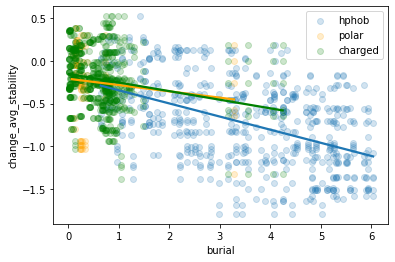

In [99]:
plot_()

In [ ]:
plot_()

In [ ]:
sns.regplot(x='burial', y='change_avg_stability', data=c.query('res_type=="hphob"'),
                    label='hphob', scatter_kws={'alpha':0.2}, ci=None)
plt.xticks([0,1,2,3,4,5,6])
plt.yticks([-1.5,-1,-0.5,0,0.5])

In [ ]:
np.corrcoef(c.query('res_type=="hphob"')['burial'], c.query('res_type=="hphob"')['change_avg_stability'])

In [ ]:
np.corrcoef(c.query('res_type=="polar"')['burial'], c.query('res_type=="polar"')['change_avg_stability'])

In [ ]:
np.corrcoef(c.query('res_type=="charged"')['burial'], c.query('res_type=="charged"')['change_avg_stability'])

In [ ]:
c.query('res_type=="polar"')

In [ ]:
######## just hphob
hphob=c.query('res_type=="hphob"')


sizes = []
for res in hphob['res']:
    if res in 'FILMWVY':
        sizes.append('large')
    elif res in 'A':
        sizes.append('Ala')
    #elif res in 'HRKDE':
    #    res_id.append('charged')
    #else:
    #    res_id.append('NaN')

hphob['size'] = sizes




In [ ]:
sns.regplot(x='burial', y='change_avg_stability', color='dimgray', data=hphob.query('size=="large"'), 
            label='FILMWVY', scatter_kws={'alpha':0.3}, ci=None)#,  hue='res_id')
sns.regplot(x='burial', y='change_avg_stability', color='mediumorchid', data=hphob.query('size=="Ala"'), 
            label='A', scatter_kws={'alpha':0.3}, ci=None)#,  hue='res_id')

plt.xticks([0,1,2,3,4,5,6])
plt.yticks([-1.5,-1,-0.5,0,0.5])
plt.legend()
plt.savefig('burial_hphob.svg')

In [ ]:
np.corrcoef(hphob.query('size=="large"')['burial'], hphob.query('size=="large"')['change_avg_stability'])

In [ ]:
np.corrcoef(hphob.query('size=="Ala"')['burial'], hphob.query('size=="Ala"')['change_avg_stability'])

In [ ]:
sns.distplot(c.query('res_type=="hphob"')['change_avg_stability'], label='hphob', hist=False)#, 
sns.distplot(c.query('res_type=="polar"')['change_avg_stability'], label='polar', hist=False)#, 
sns.distplot(c.query('res_type=="charged"')['change_avg_stability'], label='charged', hist=False)#, 

plt.legend()
plt.savefig('hist_change_mut_score.svg')

In [ ]:
sns.distplot(hphob.query('size=="large"')['change_avg_stability'], label='FILMWVY', hist=False, color='dimgray')#, 
sns.distplot(hphob.query('size=="Ala"')['change_avg_stability'], label='Ala', hist=False, color='mediumorchid')#, 
#sns.distplot(c.query('res_type=="charged"')['change_avg_stability'], label='charged', hist=False)#, 

plt.legend()
plt.savefig('hist_change_mut_scorehphob.svg')

In [ ]:
sns.distplot(c.query('res_type=="hphob"')['burial'], label='hphob', hist=False)#, 
sns.distplot(c.query('res_type=="polar"')['burial'], label='polar', hist=False)#, 
sns.distplot(c.query('res_type=="charged"')['burial'], label='charged', hist=False)#, 

           # label='hphob', scatter_kws={'alpha':0.1},)#,  hue='res_id')

#sns.regplot(x='burial', y='avg_mut_stability', data=df4.query('res_type=="charged"'), 
 #           label='charged', scatter_kws={'alpha':0.1},)#,  hue='res_id')

#sns.regplot(x='burial', y='avg_mut_stability', data=df4.query('res_type=="polar"'), 
 #           label='polar', scatter_kws={'alpha':0.1},)#,  hue='res_ida')
plt.legend()
plt.savefig('distplot_burial.svg')

In [ ]:
sns.distplot(hphob.query('size=="large"')['burial'], label='FILMWVY', hist=False, color='dimgrey')#, 
sns.distplot(hphob.query('size=="Ala"')['burial'], label='Ala', hist=False, color='mediumorchid')#, 
#sns.distplot(c.query('res_type=="charged"')['change_avg_stability'], label='charged', hist=False)#, 

plt.legend()
plt.savefig('histplot_hphob_burial.svg')

In [ ]:
sns.regplot(x='n_contacts', y='avg_change_mut_stability', data=df.query('res_id=="hphob"'), scatter_kws={'alpha':0.1},)#,  hue='res_id')

sns.regplot(x='n_contacts', y='avg_change_mut_stability', data=df.query('res_id=="charged"'), scatter_kws={'alpha':0.1},)#,  hue='res_id')

sns.regplot(x='n_contacts', y='avg_change_mut_stability', data=df.query('res_id=="polar"'), scatter_kws={'alpha':0.1},)#,  hue='res_id')
plt.legend()
#plt.savefig('n_contacts_all_res_types.svg')



In [ ]:
sns.regplot(x='n_contacts', y='avg_change_mut_stability', data=df.query('res_id=="hphob"'), scatter_kws={'alpha':0.1},)#,  hue='res_id')
np.corrcoef(df.query('res_id=="hphob"')['n_contacts'], df.query('res_id=="hphob"')['avg_change_mut_stability'])


In [ ]:
sns.regplot(x='n_contacts', y='avg_change_mut_stability', data=df.query('res_id=="hphob"'), scatter_kws={'alpha':0.1},)#,  hue='res_id')
plt.yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1])
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14])
plt.savefig('n_contacts_hphob.svg')


In [ ]:
sns.regplot(x='n_contacts', y='avg_change_mut_stability', data=df.query('res_id=="polar"'), color='orange', scatter_kws={'alpha':0.1},)#,  hue='res_id')
plt.yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1])
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14])
#plt.savefig('n_contacts_polar.svg')  

In [ ]:
sns.regplot(x='n_contacts', y='avg_change_mut_stability', data=df.query('res_id=="charged"'), color='green', scatter_kws={'alpha':0.1},)#,  hue='res_id')
plt.yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1])
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14])
plt.savefig('n_contacts_charged.svg') 

In [ ]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=df,  hue='res_id')
#plt.savefig('n_contacts.svg')
#scatter_kws={'alpha':0.1},

In [ ]:
res_types = []

for res in df['res1']:
    if res =='A':
        res_types.append('A')
    if res in 'LIV':
        res_types.append('LIV')
    if res in 'FW':
        res_types.append('FW')
df['res_type'] = res_types

In [ ]:
df.head()

In [ ]:
sns.countplot(df['res1'])

In [ ]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=df, hue='res_type')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

In [ ]:
df.query('n_contacts==10')

In [ ]:
df

In [ ]:
sns.countplot(df.query('pos1==39')['res1'])

In [ ]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=df.query('pos1==39'))
                                                                      
                                                                      #hue='change_avg_mut_stability', s=100)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

In [ ]:
df

In [ ]:
sns.scatterplot(x='pos1', y='res1', data=df.query('n_contacts==5'), hue='change_avg_mut_stability')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

In [ ]:
sns.scatterplot(x='pos1', y='res1', data=df.query('n_contacts==4'), hue='design')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

In [ ]:
sns.scatterplot(x='pos1', y='res1', data=df.query('n_contacts==4'), hue='change_avg_mut_stability')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

In [ ]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=df, hue='design')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

In [ ]:
len(df)

In [ ]:
df

In [ ]:
sns.regplot(x='n_contacts', y='change_avg_mut_stability', data=df, scatter_kws={'alpha':0.1}, hue='res_id')
#plt.savefig('n_contacts.svg')

In [ ]:
sns.regplot(x='n_contacts', y='change_avg_mut_stability', data=df, scatter_kws={'alpha':0.1})
plt.savefig('n_contacts.svg')

In [ ]:
pwd

In [ ]:
sns.scatterplot(x='pos1', y='res1', data=df.query('n_contacts==2'))#, hue='design')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

In [ ]:
sns.distplot(a['dist'])

In [ ]:
sns.displot(a['change_avg_stability'])